In [1]:
import numpy as np
import pandas as pd
import sqlite3

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, dollar_format

from ipynb.fs.defs.market_rank import (
    get_return_history,
    get_quantile_history,
    get_rank_history,
    get_tail_days)

# GET PRICE AND RANK HISTORY

In [2]:
con = sqlite3.connect('market.db')

price_history = (pd.read_sql('''
    SELECT Date, Symbol, Adj_Close AS Close
    FROM histories
    WHERE Symbol IN (
        SELECT Symbol
        FROM sp5_list) 
    ''', con, parse_dates=['Date'])
    .pivot(index='Date', columns='Symbol', values='Close'))

# display(price_history)

In [3]:
return_window = 63
quantile_window = 252
quantile = 0.75
rank_window = 2*252

rank_history = (price_history
    .pipe(get_return_history, return_window)
    .pipe(get_quantile_history, quantile_window, quantile)
    .pipe(get_tail_days, rank_window)
    .pipe(get_rank_history)
)

# display(rank_history)

# TRADE

In [4]:
def trade(price_history, rank_history, rank_keep=20, num_hold=10, init_cash= 5_000):

    cash = init_cash
    positions = pd.Series(dtype='float64')
    values = pd.Series(dtype='float64')
    trans_history = pd.DataFrame()

    for date, _ in rank_history.iterrows():
        prices = price_history.loc[date]  
        ranks = rank_history.loc[date]

        # GET SELL SYMBOLS
        logic1 = ranks > rank_keep
        logic2 = ranks.index.isin(positions.index)
        ranks_sell = ranks[logic1 & logic2]
        symbols_sell = ranks_sell.sort_values(ascending=False).index.to_list()

        # SELL
        for symbol in symbols_sell:
            trans = {
                'Date': date,
                'Action': 'Sell',
                'Qty': positions[symbol],
                'Symbol': symbol,
                'Price': prices[symbol],
                'Change': +positions[symbol]*prices[symbol],
                'Rank': ranks[symbol]}

            positions = positions.drop(symbol)
            cash += trans['Change']
            trans_history = pd.concat([trans_history,
                pd.DataFrame(trans, index=[0])], ignore_index=True)

        num_buy = num_hold - len(positions)
        if num_buy > 0:
            cash_per = cash/num_buy

            # GET BUY SYMBOLS
            logic1 = prices <= cash_per
            logic2 = ranks.index.isin(prices[logic1].index)
            logic3 = ranks.index.isin(positions.index)
            ranks_buy = ranks[logic2 & ~logic3].nsmallest(num_buy)
            symbols_buy = ranks_buy.index.to_list()

            # BUY
            for symbol in symbols_buy:
                trans = {
                    'Date': date,
                    'Action': 'Buy',
                    'Qty': int(cash_per/prices[symbol]),
                    'Symbol': symbol,
                    'Price': prices[symbol],
                    'Change': -int(cash_per/prices[symbol])*prices[symbol],
                    'Rank': ranks[symbol]}

                positions[symbol] = trans['Qty']
                cash += trans['Change']
                trans_history = pd.concat([trans_history,
                    pd.DataFrame(trans, index=[0])], ignore_index=True)

        value = cash + (positions*prices).sum()
        values[date] = value
        

    # GET OWN SYMBOLS
    logic = ranks.index.isin(positions.index)
    ranks_own = ranks[logic].sort_values()
    symbols_own = ranks_own.index.to_list()
    
    # OWN
    for symbol in symbols_own:
        trans = {
            'Date': date,
            'Action': 'Own',
            'Qty': positions[symbol],
            'Symbol': symbol,
            'Price': prices[symbol],
            'Change': +positions[symbol]*prices[symbol],
            'Rank': ranks[symbol]}

        trans_history = pd.concat([trans_history,
            pd.DataFrame(trans, index=[0])], ignore_index=True)

    return values, trans_history

In [5]:
values, trans_history = trade(price_history, rank_history)

display(trans_history)

,Date,Action,Qty,Symbol,Price,Change,Rank
0,2020-05-11,Buy,8,ENPH,59.580002,-476.640015,1
1,2020-05-11,Buy,3,TSLA,162.257996,-486.773987,2
2,2020-05-11,Buy,4,SEDG,122.940002,-491.760010,3
3,2020-05-11,Buy,1,DXCM,421.359985,-421.359985,4
4,2020-05-11,Buy,7,MRNA,66.900002,-468.300011,5
5,2020-05-11,Buy,6,ETN,77.654160,-465.924957,6
6,2020-05-11,Buy,8,AMD,55.740002,-445.920013,7
7,2020-05-11,Buy,4,GNRC,103.849998,-415.399994,8
8,2020-05-11,Buy,4,QRVO,101.900002,-407.600006,10
9,2020-05-11,Buy,24,CZR,20.620001,-494.880020,11


In [6]:
display(trans_history
    .sort_values(['Symbol', 'Date'])
    .set_index(['Symbol', 'Date']))

Action  Qty       Price       Change  Rank
Symbol Date                                                 
ALGN   2020-07-14    Buy    3  299.619995  -898.859985     7
       2021-08-16   Sell    3  690.750000  2072.250000    23
AMD    2020-05-11    Buy    8   55.740002  -445.920013     7
       2020-07-24   Sell    8   69.400002   555.200012    21
       2022-03-16    Buy   11  115.370003 -1269.070030     9
       2022-05-09    Own   11   89.010002   979.110023     9
APA    2022-01-10    Buy  101   29.223789 -2951.602711     6
       2022-05-09    Own  101   40.340000  4074.340015     2
BBWI   2020-11-25    Buy   22   31.163080  -685.587765     5
       2022-03-08   Sell   22   45.590000  1002.980003    22
CZR    2020-05-11    Buy   24   20.620001  -494.880020    11
       2021-03-23   Sell   24   84.589996  2030.159912    21
DVN    2021-12-29    Buy   34   44.200001 -1502.800026     4
       2022-05-09    Own   34   64.098999  2179.365967     5
DXCM   2020-05-11    Buy    1  421.359985  -421.359985     4
       2021-01-11   Sell    1  370.640015   370.640015    21
ENPH   2020-05-11    Buy    8   59.580002  -476.640015     1
       2021-12-29   Sell    8  185.470001  1483.760010    22
ETN    2020-05-11    Buy    6   77.654160  -465.924957     6
       2020-08-24   Sell    6  100.183640   601.101837    25
ETSY   2020-08-24    Buy    4  128.740005  -514.960022     6
       2021-08-25   Sell    4  202.279999   809.119995    26
F      2022-01-13    Buy   21   24.727501  -519.277519     7
       2022-04-11   Sell   21   15.179008   318.759178    21
FANG   2021-08-25    Buy   10   74.357994  -743.579941     8
       2022-05-09    Own   10  132.649994  1326.499939    16
FCX    2021-01-11    Buy   12   29.931953  -359.183441     7
       2022-01-13   Sell   12   44.191471   530.297653    23
FTNT   2022-02-17    Buy    8  310.540009 -2484.320068     7
       2022-05-09    Own    8  249.880005  1999.040039    15
GNRC   2020-05-11    Buy    4  103.849998  -415.399994     8
       2020-07-14   Sell    4  131.130005   524.520020    21
IT     2022-04-11    Buy    1  288.790009  -288.790009     8
       2022-05-09    Own    1  244.559998   244.559998    10
MRNA   2020-05-11    Buy    7   66.900002  -468.300011     5
       2022-05-09    Own    7  138.816101   971.712708     1
MRO    2021-03-23    Buy  204   10.024014 -2044.898758     5
       2022-05-09    Own  204   25.465000  5194.860031     4
NUE    2022-03-08    Buy    9  125.959999 -1133.639992     8
       2022-05-09    Own    9  131.643707  1184.793365    12
NVDA   2022-01-19    Buy    5  250.669998 -1253.349991     8
       2022-05-09    Own    5  175.712097   878.560486     3
OXY    2021-08-16    Buy   91   24.713015 -2248.884329     7
       2022-01-10   Sell   91   32.302906  2939.564449    21
PENN   2020-07-24    Buy   17   34.779999  -591.259979     9
       2021-10-15   Sell   17   77.699997  1320.899948    24
QRVO   2020-05-11    Buy    4  101.900002  -407.600006    10
       2020-11-25   Sell    4  148.240005   592.960022    21
SBNY   2021-08-10    Buy    4  252.968552 -1011.874207     5
       2022-03-16   Sell    4  319.784790  1279.139160    24
SEDG   2020-05-11    Buy    4  122.940002  -491.760010     3
       2021-08-10   Sell    4  296.399994  1185.599976    21
TPR    2021-10-15    Buy   35   38.712467 -1354.936352     7
       2022-01-19   Sell   35   37.233517  1303.173084    21
TSLA   2020-05-11    Buy    3  162.257996  -486.773987     2
       2022-02-17   Sell    3  876.349976  2629.049927    21

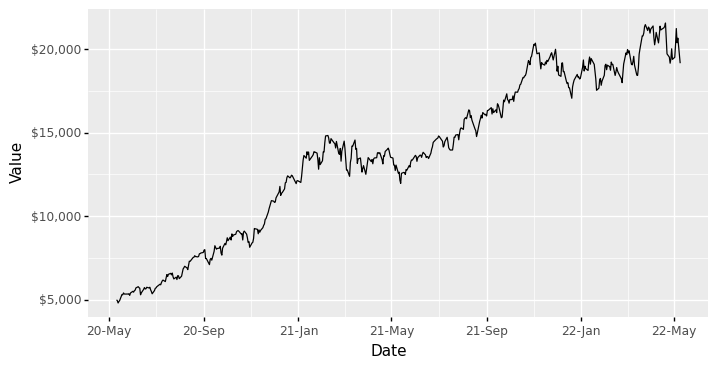

<ggplot: (8765709994183)>

In [7]:
df = values.reset_index().rename(columns={'index': 'Date', 0: 'Value'})

p = (p9.ggplot(data=df, mapping=p9.aes(x='Date', y='Value'))
    + p9.theme(figure_size=(8, 4))
    + p9.scale_x_datetime(breaks=date_breaks('4 months'), labels=date_format('%y-%b'))
    + p9.geom_line()
    + p9.scale_y_continuous(labels=dollar_format(prefix='$', digits=0, big_mark=','))
    )

display(p)